In [650]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [651]:
ideas_id = pd.read_csv("data/ideas_id.csv",index_col=0)
ideas_votes = pd.read_csv("data/ideas_votes.csv",index_col=0)
politicians_id = pd.read_csv("data/politicians_id1.csv",index_col=0,sep=None)
politicians_votes = pd.read_csv("data/politicians_votes.csv",index_col=0)

C:\Users\Reda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [652]:
# ideas_id.head()
ideas_votes.head()
# politicians_id.head()
politicians_votes.head()
# ideas_id.shape
# politicians_id.shape

,z1,z2,y
round,,,
1,20,5,0
2,5,16,0
3,7,22,0
4,1,15,0
5,9,5,0


In [653]:
print(a)
np.where(a>0)[0][-1]

[ 1  2 -1 -3  1]


4

In [654]:
def loss_f(y_pred,y):
    return y_pred + y - 2*y*y_pred

def proj(v):
    mu = np.flip(np.sort(v),axis=-1)
    _mu = mu - (np.cumsum(mu)-1)/np.arange(1,len(v)+1)
    rho = np.where(_mu>0)[0][-1]
    theta = (np.sum(mu[:rho])-1)/(rho+1)
    projected = v-theta
    projected[projected<0] = 0
    return projected/np.sum(projected)

def exprts(z_1,z_2,N):
    l = [[],[]]
    for k in range(N):
        if k==z_1:
            l[0].append(1),l[0].append(0)
            l[1].append(k),l[1].append(k+N)
        elif k==z_2:
            l[0].append(0),l[0].append(1)
            l[1].append(k),l[1].append(k+N)
    l[0] = np.array(l[0])
    return l

### Question 4: EWA, OGD and Prod forecaster

In [757]:
class EWA():
    def __init__(self,data,N,T=15000,eta=.8):
        self.N = N            # K is the number of experts
        self.T = T            # T is the time horizon
        self.eta = eta        # eta is the ewa parameter
        self.p = np.ones(2*N)/(2*N)
        self.p_hat = np.ones(2*N)/(2*N)
        self.loss = list()
        self.loss.append(0)
        self.losses = -np.ones((T,2*N))
        self.data = data
        self.pred = list()
    def ewa(self):
        z_1 = self.data["z1"].values
        z_2 = self.data["z2"].values
        y = self.data["y"].values
        for t in range(T):
            experts, indices = exprts(z_1[t],z_2[t],self.N)
            rest = [i  for i in range(2*self.N) if (i not in indices)]
            self.p[rest] = 0
            if np.sum(self.p)==0:
                self.p[indices]=1
            self.p /= np.sum(self.p)
            self.losses[t][indices] = loss_f(experts,y[t])
            self.loss.append(np.dot(self.p,self.losses[t]))
            self.losses[t][rest] = self.loss[-1]
            self.pred.append((np.random.uniform()<np.dot(self.p[indices],experts))!=y[t])
            self.p_hat = np.multiply(self.p_hat,np.exp(-self.eta*self.losses[t]))
            self.p_hat /= np.sum(self.p_hat)
            self.p = np.copy(self.p_hat)
    
class OGD(EWA):
    def __init__(self,data,N,T,eta):
        super().__init__(data,N,T,eta)
    
    def ogd(self):
        z_1 = self.data["z1"].values
        z_2 = self.data["z2"].values
        y = self.data["y"].values
        for t in range(T):
            experts, indices = exprts(z_1[t],z_2[t],self.N)
            rest = [i  for i in range(2*self.N) if (i not in indices)]
            self.p[rest] = 0
            if np.sum(self.p)==0:
                self.p[indices] = 1
            self.p /= np.sum(self.p)
            self.losses[t][indices] = loss_f(experts,y[t])
            self.loss.append(np.dot(self.p,self.losses[t]))
            self.losses[t][rest] = self.loss[-1]
            self.pred.append((np.random.uniform()<np.dot(self.p[indices],experts))!=y[t])
            self.p_hat[indices] -= self.eta*(1-2*y[t])*experts
            self.p_hat[rest] -= self.eta*(1-2*y[t])*np.dot(self.p[indices],experts)
            self.p_hat = proj(self.p_hat)
            self.p = np.copy(self.p_hat)
            
    def ogd_bis(self):
        z_1 = self.data["z1"].values
        z_2 = self.data["z2"].values
        y = self.data["y"].values
        for t in range(T):
            experts, indices = exprts(z_1[t],z_2[t],self.N)
            rest = [i  for i in range(2*self.N) if (i not in indices)]
            self.p[rest] = 0
            if np.sum(self.p)==0:
                self.p[indices] = 1
            self.p /= np.sum(self.p)
            self.losses[t][indices] = loss_f(experts,y[t])
            self.loss.append(np.dot(self.p,self.losses[t]))
            self.losses[t][rest] = self.loss[-1]
            self.pred.append((np.random.uniform()<np.dot(self.p[indices],experts))!=y[t])
            self.p_hat[indices] -= self.eta*(1-2*y[t])*experts
#             self.p_hat[rest] -= self.eta*(1-2*y[t])*np.dot(self.p[indices],experts)
            self.p_hat = proj(self.p_hat)
            self.p = np.copy(self.p_hat)
    
class Prod(EWA):
    def __init__(self,data,N,T,eta):
        super().__init__(data,N,T,eta)
        self.eta = np.ones(2*N)*eta
        self.w = np.ones(2*N)
    def prod(self):
        z_1 = self.data["z1"].values
        z_2 = self.data["z2"].values
        y = self.data["y"].values
        for t in range(T):
            experts, indices = exprts(z_1[t],z_2[t],self.N)
            rest = [i  for i in range(2*self.N) if (i not in indices)]
            self.p[rest] = 0
            if np.sum(self.p)==0:
                self.p[indices]=1
            self.p /= np.sum(self.p)
            self.losses[t][indices] = loss_f(experts,y[t])
            self.loss.append(np.dot(self.p,self.losses[t]))
            self.losses[t][rest] = self.loss[-1]
            self.pred.append((np.random.uniform()<np.dot(self.p[indices],experts))!=y[t])
            self.w = self.w*(1+self.eta*(np.dot(self.p_hat,self.losses[t])-self.losses[t]))
            self.p_hat = self.eta*self.w
            self.p_hat /= np.sum(self.p_hat)
            self.p = np.copy(self.p_hat)
            
class BD(EWA):
    def __init__(self,data,N,T):
        self.N = N            # K is the number of experts
        self.T = T            # T is the time horizon
        self.p_hat = np.ones(N)/N
        self.loss = list(); self.loss.append(0)
        self.data = data
        self.pred = list()
        self.w = np.zeros((N,N))+1e-7
    
    def bd(self):
        z_1 = self.data["z1"].values
        z_2 = self.data["z2"].values
        y = self.data["y"].values
        for t in range(T):
            pred = self.p_hat[z_1[t]-1]/(self.p_hat[z_2[t]-1]+self.p_hat[z_1[t]-1])
            self.loss.append(loss_f(y[t],pred))
            self.pred.append((np.random.uniform()<pred)!=y[t])
            self.w[z_1[t]-1][z_2[t]-1] += y[t]
            self.w[z_2[t]-1][z_1[t]-1] += 1-y[t]
            _M = (self.w + self.w.T)/(self.p_hat[None,:]+self.p_hat[:,None])
            self.p_hat = np.sum(self.w,axis=1)/(np.sum(_M,axis=0)-np.diagonal(_M))
            self.p_hat /= np.sum(self.p_hat)


In [787]:
def test_forecaster(N,T,eta=0.1,data=ideas_votes,forecaster='EWA'):
    if forecaster=='EWA':
        obj = EWA(data,N,T,eta)
        obj.ewa()
        loss = obj.loss
        pred = np.array(obj.pred)
    elif forecaster=='OGD':
        obj = OGD(data,N,T,eta)
        obj.ogd()
        loss = obj.loss
        pred = np.array(obj.pred)
    elif forecaster=='OGD_bis':
        obj = OGD(data,N,T,eta)
        obj.ogd_bis()
        loss = obj.loss
        pred = np.array(obj.pred)
    elif forecaster=='Prod':
        obj = Prod(data,N,T,eta)
        obj.prod()
        loss = obj.loss
        pred = np.array(obj.pred)
    elif forecaster=='Bradley Terry':
        obj = BD(data,N,T)
        obj.bd()
        loss = obj.loss
        pred = np.array(obj.pred)
    else:
        print("wrong algorithm")
    return loss, pred

plt.style.use('seaborn')

def plot_res(losses,preds,name="Ideas",labels=['EWA', 'OGD', 'OGD_bis', 'Prod', 'Bradley Terry']):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    for i in range(len(losses)):     
        axs[0].plot(np.cumsum(losses[i])[100:]/np.arange(101,len(losses[i])+1),label=labels[i]+" L_t/t")
    axs[0].set_title("L_t / t",fontsize=16)
    axs[0].legend()
    for i in range(len(preds)): 
        axs[1].plot(np.cumsum(preds[i])[100:]/np.arange(101,len(preds[i])+1),label=labels[i])
    axs[1].set_title("True average loss",fontsize=16)
    axs[1].legend()
    fig.suptitle(name+" Dataset", fontsize=20)

In [789]:
N = 261 # ideas dataset contains 261 idea
T = 15000
eta_ewa = np.sqrt(np.log(2*N)/T)
eta_ogd = 1/np.sqrt(N*T)
eta_prod = np.sqrt(N*np.log(2*N)/T)

loss_ewa, pred_ewa = test_forecaster(N,T,eta_ewa,ideas_votes,forecaster='EWA')
loss_ogd, pred_ogd = test_forecaster(N,T,eta_ogd,ideas_votes,forecaster='OGD')
loss_ogd_bis, pred_ogd_bis = test_forecaster(N,T,eta_ogd,ideas_votes,forecaster='OGD_bis')
loss_prod, pred_prod = test_forecaster(N,T,eta_prod,ideas_votes,forecaster='Prod')
loss_BD, pred_BD = test_forecaster(N,T,.1,ideas_votes,forecaster='Bradley Terry')

losses=[loss_ewa,loss_ogd,loss_ogd_bis,loss_prod,loss_BD]
preds=[pred_ewa,pred_ogd,pred_ogd_bis,pred_prod,pred_BD]

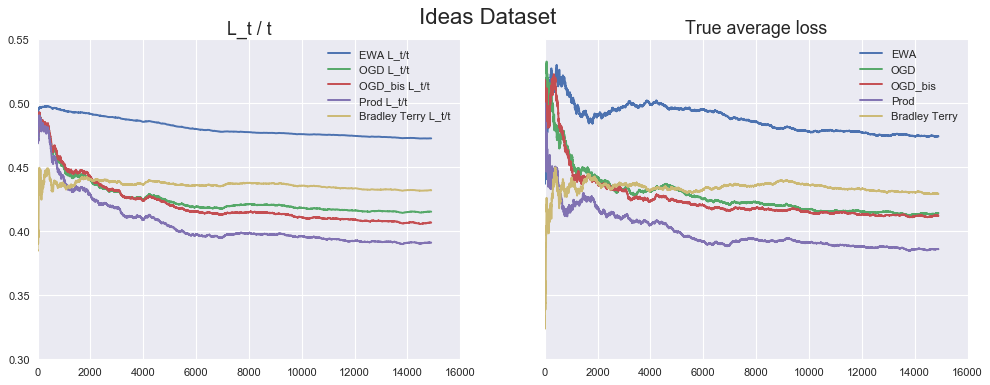

In [788]:
plot_res(losses,preds)

In [790]:
N = 39 # politicians dataset contains 261 politician
T = 15000
eta_ewa = np.sqrt(np.log(2*N)/T)
eta_ogd = 1/np.sqrt(N*T)
eta_prod = np.sqrt(N*np.log(2*N)/T)

loss_ewa, pred_ewa = test_forecaster(N,T,eta_ewa,politicians_votes,forecaster='EWA')
loss_ogd, pred_ogd = test_forecaster(N,T,eta_ogd,politicians_votes,forecaster='OGD')
loss_ogd_bis, pred_ogd_bis = test_forecaster(N,T,eta_ogd,politicians_votes,forecaster='OGD_bis')
loss_prod, pred_prod = test_forecaster(N,T,eta_prod,politicians_votes,forecaster='Prod')
loss_BD, pred_BD = test_forecaster(N,T,.1,politicians_votes,forecaster='Bradley Terry')

losses_politicians=[loss_ewa,loss_ogd,loss_ogd_bis,loss_prod,loss_BD]
preds_politicians=[pred_ewa,pred_ogd,pred_ogd_bis,pred_prod,pred_BD]

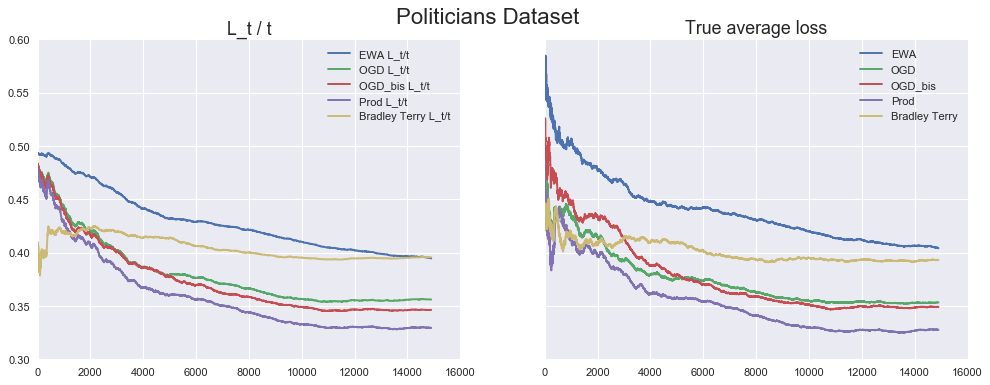

In [801]:
plot_res(losses_politicians,preds_politicians,name='Politicians')

Text(0.5, 0.98, 'Cumulative loss')

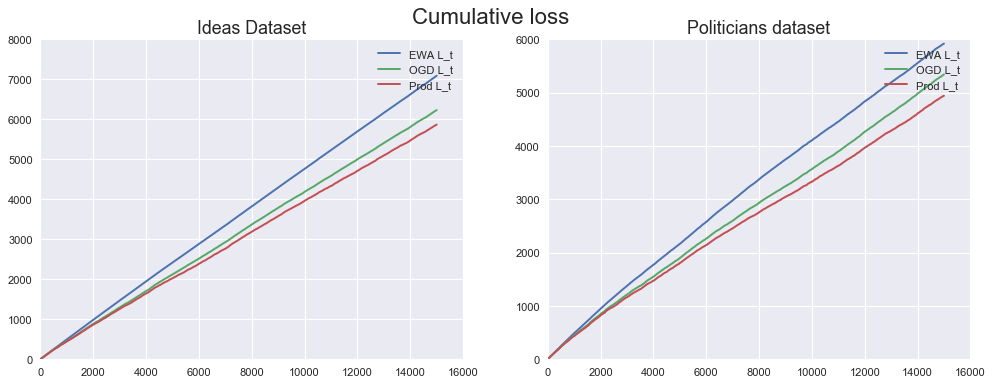

In [793]:
labels=['EWA', 'OGD', 'OGD_bis', 'Prod', 'Bradley Terry']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.cumsum(losses[0]),label=labels[0]+" L_t")
axs[0].plot(np.cumsum(losses[1]),label=labels[1]+" L_t")
axs[0].plot(np.cumsum(losses[3]),label=labels[3]+" L_t")
axs[0].set_title("Ideas Dataset",fontsize=16)
axs[0].legend()

axs[1].plot(np.cumsum(losses_politicians[0]),label=labels[0]+" L_t")
axs[1].plot(np.cumsum(losses_politicians[1]),label=labels[1]+" L_t")
axs[1].plot(np.cumsum(losses_politicians[3]),label=labels[3]+" L_t")
axs[1].set_title("Politicians dataset",fontsize=16)
axs[1].legend()
fig.suptitle("Cumulative loss", fontsize=20)

Text(0, 0.5, 'final loss')

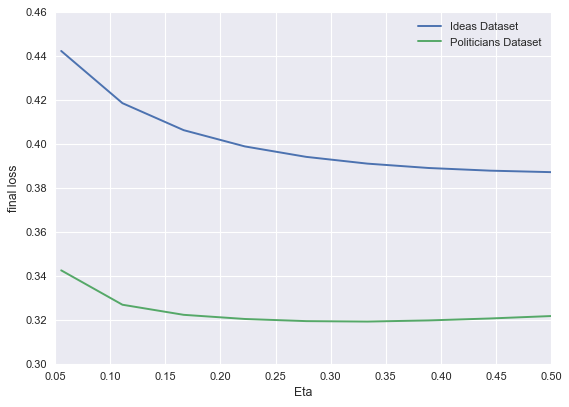

In [800]:
errors_1 = [0.44213714657541325,0.41841328763700614, 0.40613892191248896, 0.39874554563055359, 0.39400365992192921, 0.39092843049181264, 0.3889413576278008, 0.38773647286355561, 0.38705533721596053]
errors_2 = [0.34242039024756848, 0.32678889085271456, 0.32220285818032213, 0.32031147774901464, 0.31933806970352485, 0.31913442281835763,0.31965702340937147,0.32053928341723348,0.32164667072810194]
etas = [ 0.05555556,  0.11111111,  0.16666667,  0.22222222,  0.27777778, 0.33333333,  0.38888889,  0.44444444,  0.5       ]
plt.plot(etas,errors_1,label="Ideas Dataset")
plt.plot(etas,errors_2,label="Politicians Dataset")
plt.legend()
plt.xlabel("Eta")
plt.ylabel("final loss")